In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import imageio
import scipy.stats as stats
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
# loading the HIL library 
from HIL.cost_processing.metabolic_cost.ppe import PPE

# loading plotting modules
from HIL.plotting.utils import plot_elipses, plot_mean_estimation

In [4]:
# load the data 
import pickle
f = open("../data/full_data.pkl", "rb")
data = pickle.load(f)
f.close()

In [5]:
# loading the metabolic cost data
met_data = data["met"].T # metabolic cost and time 
m_time = data["m_time"] # marker time
m_text = data["markers"] # marker text

In [6]:
order = {k:[i,j] for i,j,k in zip(m_time[:-1], m_time[1:], m_text[:-1])} # adding markers corresponding to time
order = {k: v for k, v in sorted(order.items(), key=lambda item: item[1])} # sorting values according to time

In [7]:
order

{'Marker': [3, 100],
 'redo_stop': [100, 394],
 'baseline_start': [394, 530],
 'catch': [961, 1014],
 'asym': [1014, 1310],
 'baseline': [1310, 1559],
 'break': [1559, 1610],
 'normal walking': [1610, 1910]}

Run the following to remove the "Marker" first term 

In [8]:
order.pop('Marker')

[3, 100]

In [9]:
order

{'redo_stop': [100, 394],
 'baseline_start': [394, 530],
 'catch': [961, 1014],
 'asym': [1014, 1310],
 'baseline': [1310, 1559],
 'break': [1559, 1610],
 'normal walking': [1610, 1910]}

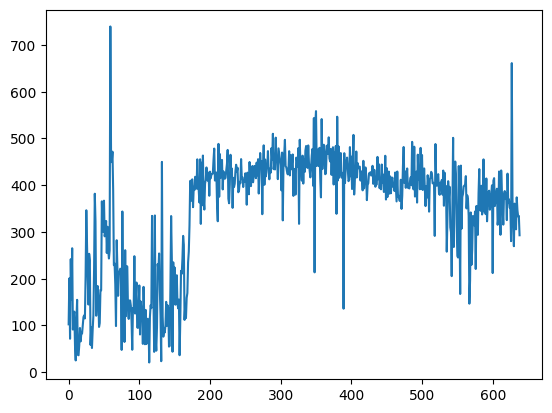

In [10]:
# plotting met data just for sanity check
plt.plot(met_data[:,0])

In [11]:
# place to store all the values
steady_state_estimation_mean = []
steady_state_estimation_std = []
steady_state_time = []
ax_list = []

In [12]:
# get the name in the order if the time is in the range
def get_name(time):
    for k,v in order.items():
        if v[0] < time < v[1]:
            return k
    return None

 25%|██▌       | 114/450 [02:12<10:28,  1.87s/it]/home/prakyath/github/research/.research/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
 53%|█████▎    | 239/450 [06:23<08:16,  2.35s/it]/home/prakyath/github/research/.research/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
 67%|██████▋   | 303/450 [08:32<06:23,  2.61s/it]/home/prakyath/github/research/.research/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
 70%|███████   | 317/450 [09:10<06:08,  2.77s/it]/home/prakyath/github/resea

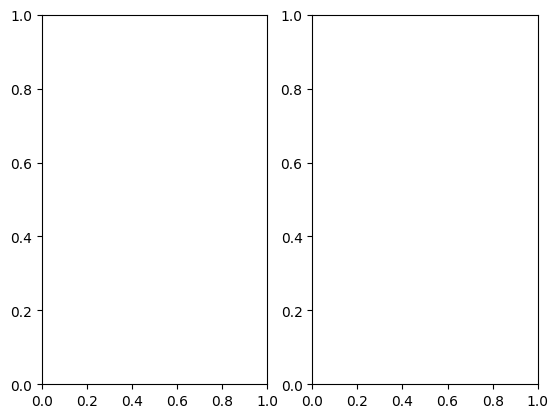

In [14]:
fig, ax = plt.subplots(1,2,)
start = 0
# place to store all the values
steady_state_estimation_mean = []
steady_state_estimation_std = []
steady_state_time = []
ax_list = []
for i in tqdm(range(150, 600)):

    # This is not necessary, just to make estimation go faster. Otherwise large number of data points will be used for estimation
    # change the number as you like
    # if i > 200:
    #     start = i - 20
    met = met_data[130:i, 0]
    time = met_data[130:i, 1]

    # upsample number should be 20 but for faster estimation we are using 5
    ppe = PPE(upsample_number=1)
    _, _ = ppe.estimate(met, time, estimate=False) #type:ignore
    # plotting phase plane
    ax[0].plot(ppe.phase_plane[:, 0], ppe.phase_plane[:, 1], label="phase plane") #type:ignore

    # limiting the data to the last 20 data points (approax 1  min)
    ppe = PPE(upsample_number=5)
    mean, std = ppe.estimate(met[-20:], time[-20:])
    steady_state_estimation_mean.append(mean)
    steady_state_estimation_std.append(std)
    steady_state_time.append(time[-1])
    plot_elipses(ppe.gmm.means_, ppe.gmm.covariances_, ax[0]) #type:ignore
    name = get_name(time[-1])
    # print(name)
    plot_mean_estimation(mean, std, ax[0], label=name) #type:ignore
    ax[0].set_xlabel("metabolic cost (W)")
    ax[0].set_ylabel("d(metabolic cost) (W)")

    # plotting time series
    ax[1].plot(time, met, label="metabolic cost")
    ax[1].plot(steady_state_time, steady_state_estimation_mean, label="estimated metabolic cost")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("metabolic cost (W)")


    plt.legend()
    canvas = FigureCanvas(fig)
    canvas.draw()       # draw the canvas, cache the renderer
    

    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8') #type:ignore
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    ax_list.append(image)
    ax[0].cla()
    ax[1].cla()



In [15]:
# save the to video
writer = imageio.get_writer('cosmed.mp4', fps=20)

for im in ax_list:
    writer.append_data(im)
writer.close()

In [16]:
met[-20:]

array([338.8396167289333, 546.5005911903334, 410.2578420094666,
       482.85696288246663, 416.08038284906667, 437.9603961859333,
       468.80717128279997, 429.5664514807333, 415.6649546955333,
       426.4881391629999, 135.94489069033332, 468.5507289781333,
       404.7026258717334, 434.9256281022666, 446.09130403239993,
       459.0858404886666, 432.2362078306666, 408.65976945153335,
       411.79711653073326, 481.5198885283333], dtype=object)